In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import os
import glob
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tempest import casestudy
from tempest import grid
from tempest import joint_distrib
from tempest import handler

from scipy.optimize import curve_fit

settings_path = 'settings/tropics.yaml'

In [3]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
# jd = joint_distrib.JointDistribution(gr)

if __name__ == '__main__':
    # print("Loaded Configuration:")
    # for key, value in settings.items():
    #     print(f"{key}: {value}")
    
    #gr.compute_funcs_for_var_id()
    pass


Data loaded from /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/grid_attributes.pkl instead of computing


# Retrieve storms object


In [16]:
jd = joint_distrib.JointDistribution(gr, nd=5, storm_tracking=True)

Distribs loaded
Overwrite set to false so loading basics attributes from .npy
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz


# Check density and storm_tracking

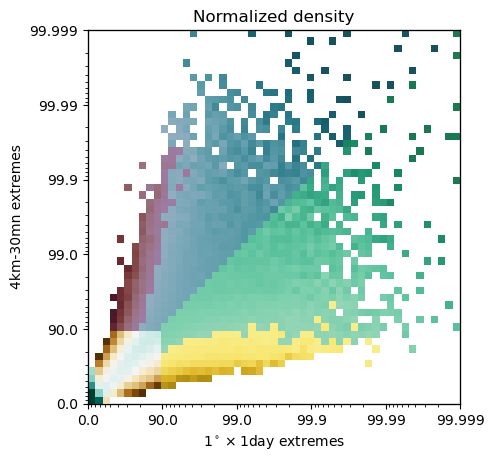

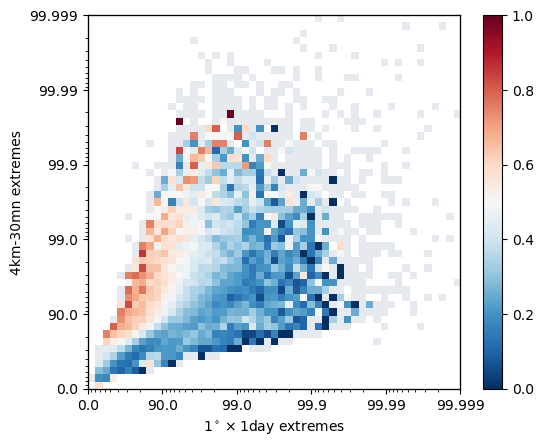

In [17]:
%matplotlib inline
jd.plot(branch=False)

data, noise = jd.get_mcs_bin_fraction()
jd.plot_data(data, noise, branch=False)

# Dev plane fit to extreme rains

True


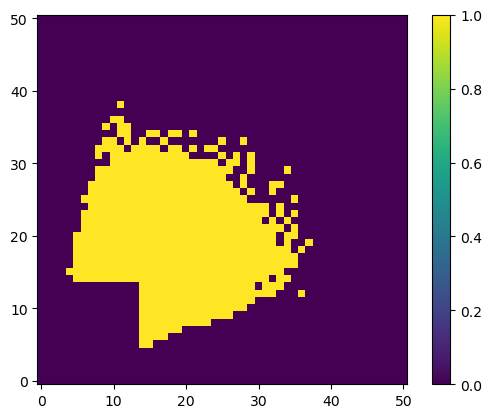

MaskError: Mask and data not compatible: data size is 5202, mask size is 2601.

In [62]:
import numpy as np
from sklearn.linear_model import LinearRegression
from numpy.ma import masked_array

# Example 2D array with np.nan values
array_2d, noise = jd.get_mcs_bin_fraction()

mask_jdist_below_treshold = np.outer(jd.dist1.ranks < 95, jd.dist2.ranks < 95)
mask_treshold_for_plane_fit = np.logical_and(~mask_jdist_below_treshold, ~np.isnan(array_2d))
plt.imshow(mask_treshold_for_plane_fit, origin = 'lower')
plt.colorbar()
print(True==1)
plt.show()

# Create masked array for y
y = masked_array(array_2d.flatten(), mask=mask_treshold_for_plane_fit.flatten())

xx, yy = np.meshgrid(np.arange(array_2d.shape[0]), np.arange(array_2d.shape[1]))

#mask corresponding X before building

# xx = masked_array(xx.flatten(), mask=mask_treshold_for_plane_fit.flatten())
# yy = masked_array(yy.flatten(), mask=mask_treshold_for_plane_fit.flatten())

# mask X although it's 2 columns
X = np.column_stack((xx, yy))
X = masked_array(X, mask=mask_treshold_for_plane_fit.flatten())

model = LinearRegression().fit(X, y)
